In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset

import pandas as pd
import shutil

import matplotlib.pyplot as plt

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score

import os
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms

In [6]:
# def process_csv(csv_path, images_folder, output_base_folder, has_labels=False):
#     df = pd.read_csv(csv_path)

#     if not os.path.exists(output_base_folder):
#         os.makedirs(output_base_folder)

#     for index, row in df.iterrows():
#         image_path = row['image_path']
#         if has_labels:
#             font = row.get('font', 'unknown_font')
#             font_size = row.get('font_size', 'unknown_size')
#             color = row.get('color', 'unknown_color').replace("#", "")

#             class_folder = os.path.join(
#                 output_base_folder,
#                 color,
#                 font,
#                 f"size_{font_size}"
#             )
#             if not os.path.exists(class_folder):
#                 os.makedirs(class_folder)
#         else:
#             class_folder = output_base_folder

#         source = os.path.join(images_folder, os.path.basename(image_path))
#         destination = os.path.join(class_folder, os.path.basename(image_path))

#         if os.path.exists(source):
#             shutil.copy2(source, destination)
#         else:
#             print(f"File {os.path.basename(image_path)} does not exist in {images_folder}")

# train_csv_path = 'C:/Users/ASUS/NextgenAI/train.csv'
# test_csv_path = 'C:/Users/ASUS/NextgenAI/test.csv'
# images_folder = 'C:/Users/ASUS/NextgenAI/images'

train_output_base_folder = 'C:/Users/ASUS/NextgenAI/train_test_pic/train_pic'
test_output_base_folder = 'C:/Users/ASUS/NextgenAI/train_test_pic/test_pic'

# process_csv(train_csv_path, images_folder, train_output_base_folder, has_labels=True)
# process_csv(test_csv_path, images_folder, test_output_base_folder, has_labels=False)

In [7]:
class MultiAlphabetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        self.color_mapping = {'FF6666': 0, '0000FF': 1, 'A020F0': 2, 'DF3030': 3, '26E953': 4}
        self.font_mapping = {'Athiti-Regular': 0, 'Sarabun-Regular': 1, 'NotoSerifThai-Regular': 2,
                             'Kodchasan-Regular': 3, 'Prompt-Regular': 4, 'KhaosuayThin': 5, 'FkBeautyRegular': 6}
        self.font_size_mapping = {18: 0, 20: 1, 22: 2, 24: 3, 26: 4, 28: 5}

        for color_dir in os.scandir(root_dir):
            if color_dir.is_dir():
                color = color_dir.name
                for font_dir in os.scandir(color_dir.path):
                    if font_dir.is_dir():
                        font = font_dir.name
                        for size_dir in os.scandir(font_dir.path):
                            if size_dir.is_dir() and size_dir.name.startswith("size_"):
                                font_size = int(size_dir.name.split('_')[1])
                                for file in os.scandir(size_dir.path):
                                    if file.is_file():
                                        self.samples.append((file.path, font, font_size, color))

        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, font, font_size, color = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Encode labels as tensors
        font_encoded = torch.tensor(self.font_mapping.get(font), dtype=torch.long)
        font_size_encoded = torch.tensor(self.font_size_mapping.get(font_size), dtype=torch.long)
        color_encoded = torch.tensor(self.color_mapping.get(color), dtype=torch.long)

        return image, color_encoded, font_encoded, font_size_encoded

In [8]:
class ReverseIntensity:
  def __init__(self, threshold=150):
    self.threshold = threshold

  def __call__(self, image):

    if isinstance(image, Image.Image):
      image_np = np.array(image)
    elif isinstance(image, np.ndarray):
      image_np = image
    else:
      raise TypeError("Unsupported type. Expected PIL Image or numpy array.")

    if np.mean(image_np) > self.threshold:
      reversed_image = 255 - image_np
      return Image. fromarray(reversed_image)
    else:
      return image

In [9]:
class MedianBlur(object):
    def __init__(self, kernel_size=1):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img = img.filter(ImageFilter.MedianFilter(size=self.kernel_size))
        return img

##apply to all train test

# Define the transform pipeline
transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(contrast=0.1),
    transforms.ToTensor(),
])
root_dir = train_output_base_folder
dataset = MultiAlphabetDataset(root_dir=root_dir, transform=transform)

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, colors, fonts, font_sizes = next(iter(dataloader))

color_names = [reverse_color_mapping[int(color)] for color in colors]
font_names = [reverse_font_mapping[int(font)] for font in fonts]
font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

print(f"Batch Images Shape: {images.shape}")
print(f"Batch Colors: {color_names}")
print(f"Batch Fonts: {font_names}")
print(f"Batch Font Sizes: {font_size_names}")

Total samples found: 10080
Batch Images Shape: torch.Size([4, 3, 224, 224])
Batch Colors: ['0000FF', 'A020F0', 'DF3030', '0000FF']
Batch Fonts: ['Kodchasan-Regular', 'Kodchasan-Regular', 'KhaosuayThin', 'FkBeautyRegular']
Batch Font Sizes: [24, 28, 18, 24]


In [10]:
class RemoveWhiteNoiseAndBackground:
    def __init__(self, threshold=(200, 200, 200)):
            self.threshold = threshold
        
    def __call__(self, img):
            # Convert image to numpy array for pixel manipulation
            img_np = np.array(img)
            
            # Create a mask for pixels that are considered white noise or background
            mask = (img_np[..., 0] >= self.threshold[0]) & \
                (img_np[..., 1] >= self.threshold[1]) & \
                (img_np[..., 2] >= self.threshold[2])
            
            # Set those pixels to black (0, 0, 0)
            img_np[mask] = [255, 255, 255]
            
            # Convert back to PIL Image
            return Image.fromarray(img_np)
import cv2
class BilateralFilter:
    def __init__(self, d=9, sigmaColor=75, sigmaSpace=75):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def __call__(self, img):
        # Convert the PIL Image to a NumPy array
        img_np = np.array(img)

        # Apply the bilateral filter using OpenCV
        filtered_img_np = cv2.bilateralFilter(img_np, self.d, self.sigmaColor, self.sigmaSpace)

        # Convert the filtered NumPy array back to a PIL Image
        filtered_img = Image.fromarray(filtered_img_np)

        return filtered_img


In [11]:
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dir = train_output_base_folder
        
    train_transform =transforms.Compose([ 
                    BilateralFilter(d=5, sigmaColor=60, sigmaSpace=60),   
                    RemoveWhiteNoiseAndBackground(),
                    transforms.RandomAffine(degrees=(0),
                                            translate=(0.05, 0.05),
                                            scale=(1.0, 1.0),
                                            shear=0),                 
                    transforms.CenterCrop((64, 512)),
                    transforms.ToTensor(),
    ])

    dataset = MultiAlphabetDataset(root_dir=root_dir, transform=train_transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [13]:
train_loader, test_loader = load_data(reverse=False, normalize=False, batch_size=32)

Total samples found: 10080


In [9]:
# def get_dataset_stats(loader):
#     font_count = {}
#     font_size_count = {}
#     color_count = {}
#     total_samples = 0

#     reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
#     reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
#     reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

#     for batch in loader:
#         images, colors, fonts, font_sizes = batch

#         color_names = [reverse_color_mapping[int(color)] for color in colors]
#         font_names = [reverse_font_mapping[int(font)] for font in fonts]
#         font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

#         for color in color_names:
#             if color not in color_count:
#                 color_count[color] = 0
#             color_count[color] += 1

#         for font in font_names:
#             if font not in font_count:
#                 font_count[font] = 0
#             font_count[font] += 1

#         for font_size in font_size_names:
#             if font_size not in font_size_count:
#                 font_size_count[font_size] = 0
#             font_size_count[font_size] += 1

#         total_samples += len(images)

#     return font_count, font_size_count, color_count, total_samples

In [14]:
# train_font_count, train_font_size_count, train_color_count, train_total_samples = get_dataset_stats(train_loader)
# test_font_count, test_font_size_count, test_color_count, test_total_samples = get_dataset_stats(test_loader)

# print("📃Train Dataset:")
# for font, count in train_font_count.items():
#     print(f"\tNumber of images with font {font}: {count}")
# for font_size, count in train_font_size_count.items():
#     print(f"\tNumber of images with font size {font_size}: {count}")
# for color, count in train_color_count.items():
#     print(f"\tNumber of images with color {color}: {count}")
# print(f"\tNumber of training samples: {train_total_samples}")

# print("📃Test Dataset:")
# for font, count in test_font_count.items():
#     print(f"\tNumber of images with font {font}: {count}")
# for font_size, count in test_font_size_count.items():
#     print(f"\tNumber of images with font size {font_size}: {count}")
# for color, count in test_color_count.items():
#     print(f"\tNumber of images with color {color}: {count}")
# print(f"\tNumber of testing samples: {test_total_samples}")

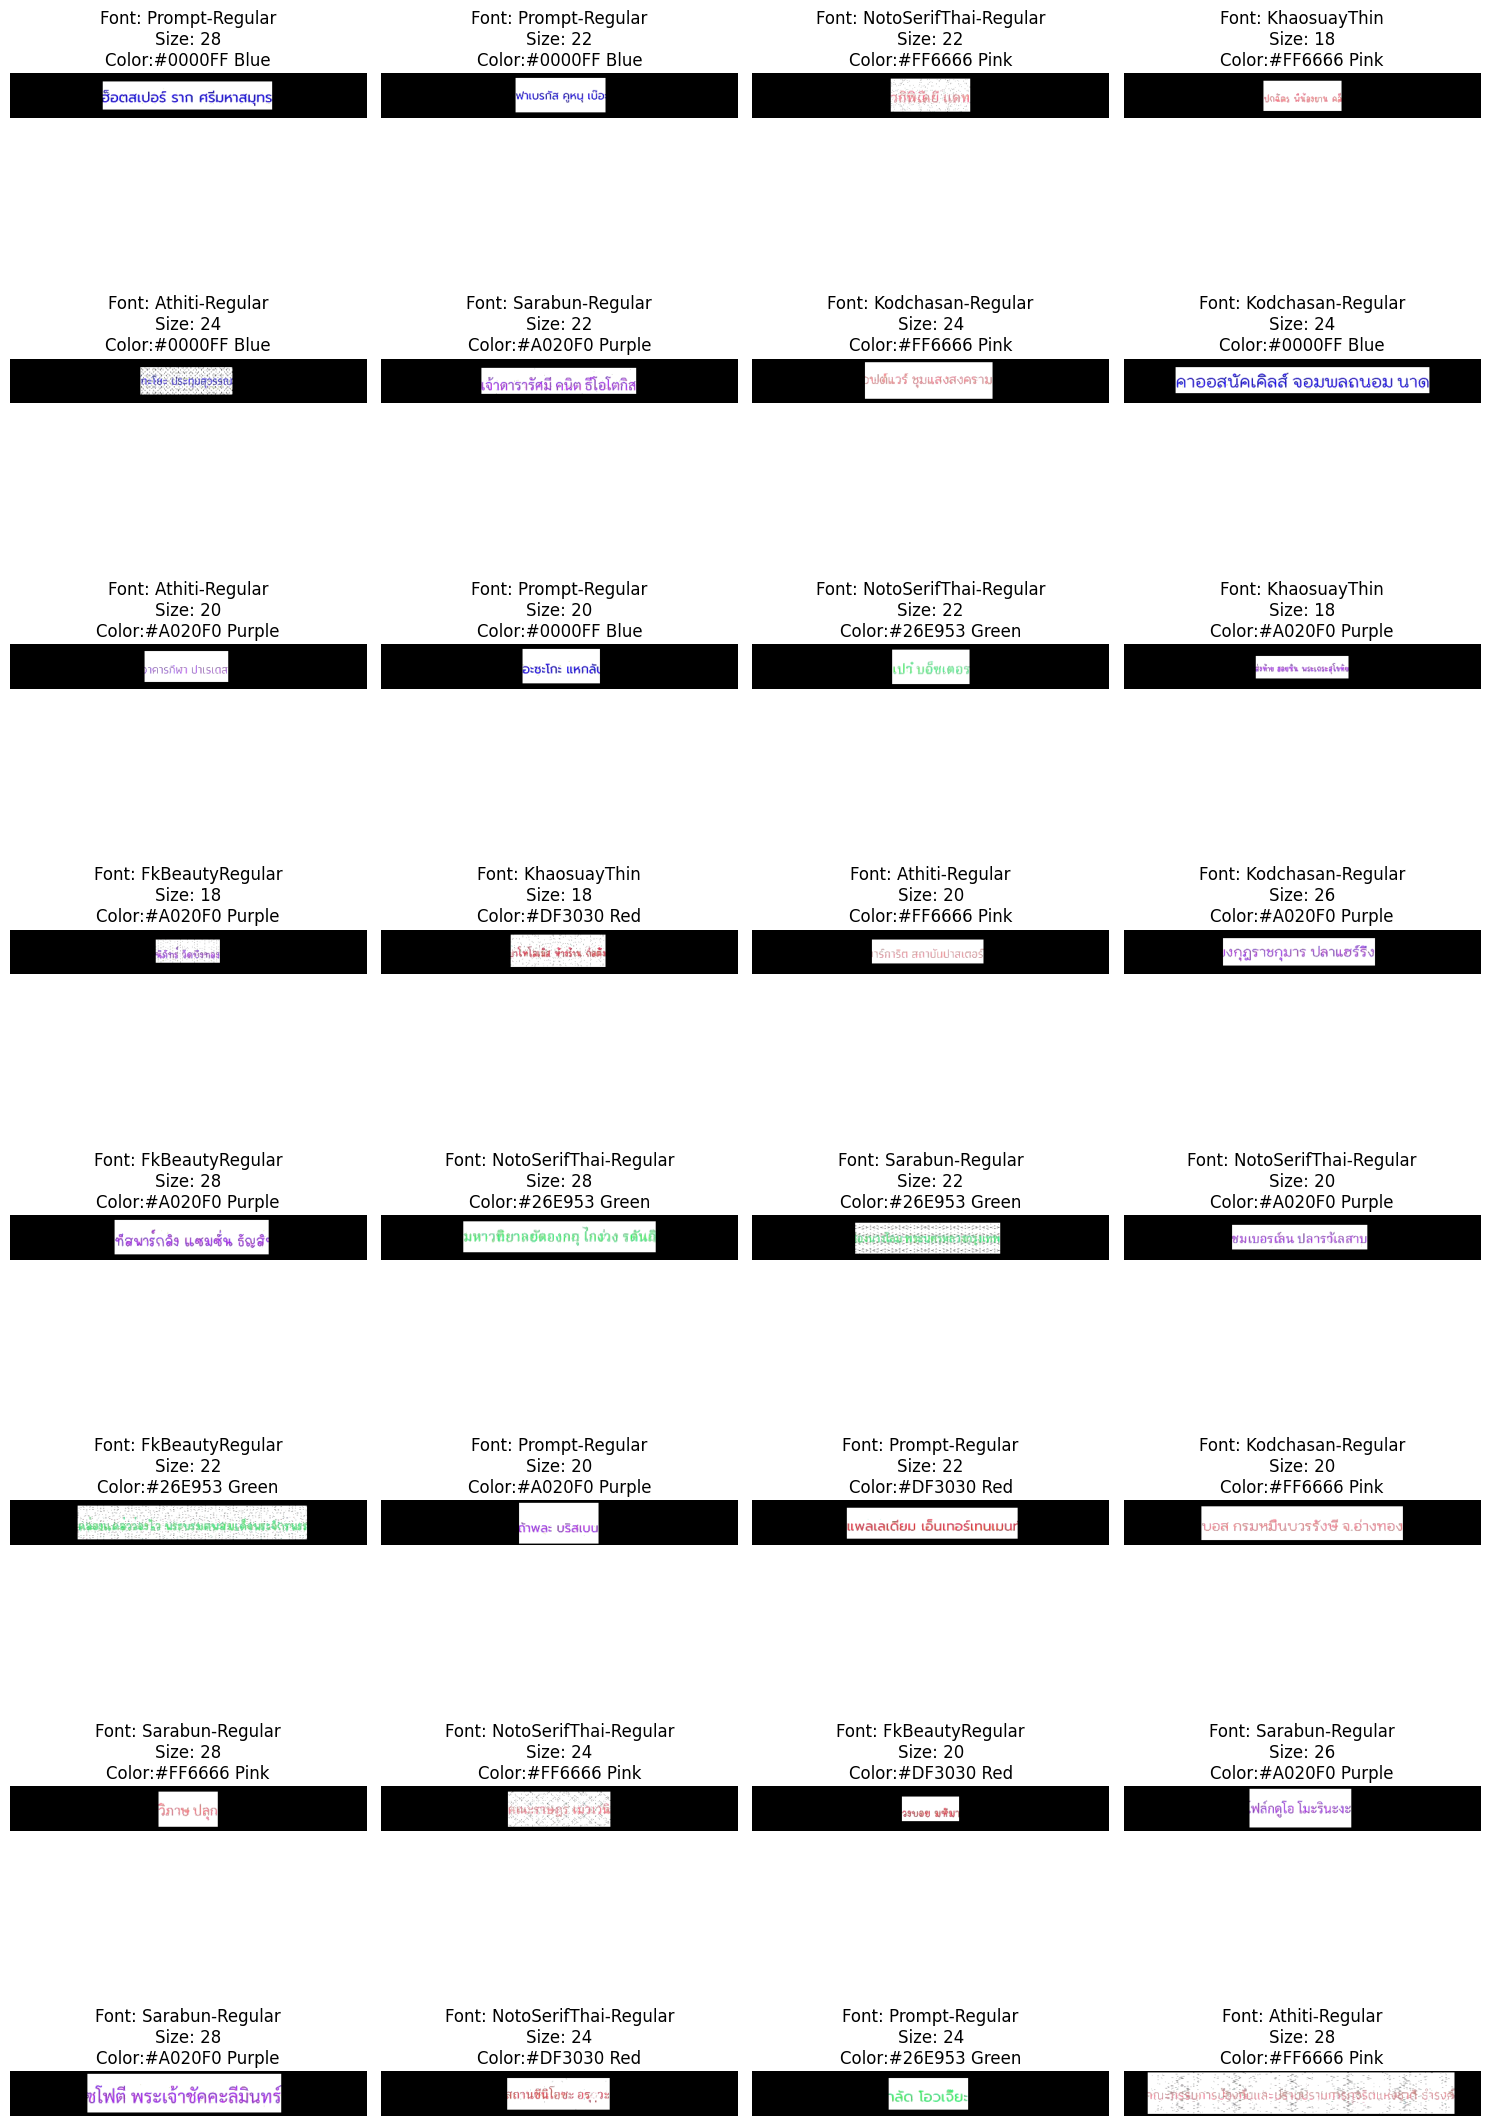

In [15]:
# TRAIN
color_name_map = {
    'FF6666': 'Pink',
    '0000FF': 'Blue',
    'A020F0': 'Purple',
    'DF3030': 'Red',
    '26E953': 'Green'
}
batch_size = 32
images, colors, fonts, font_sizes = next(iter(train_loader))

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = reverse_color_mapping[int(color)]
    # color_hex = color_name_map[color_name]
    font_name = reverse_font_mapping[int(font)]
    font_size_value = reverse_font_size_mapping[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor:#{color_name} {color_name_map[color_name]}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

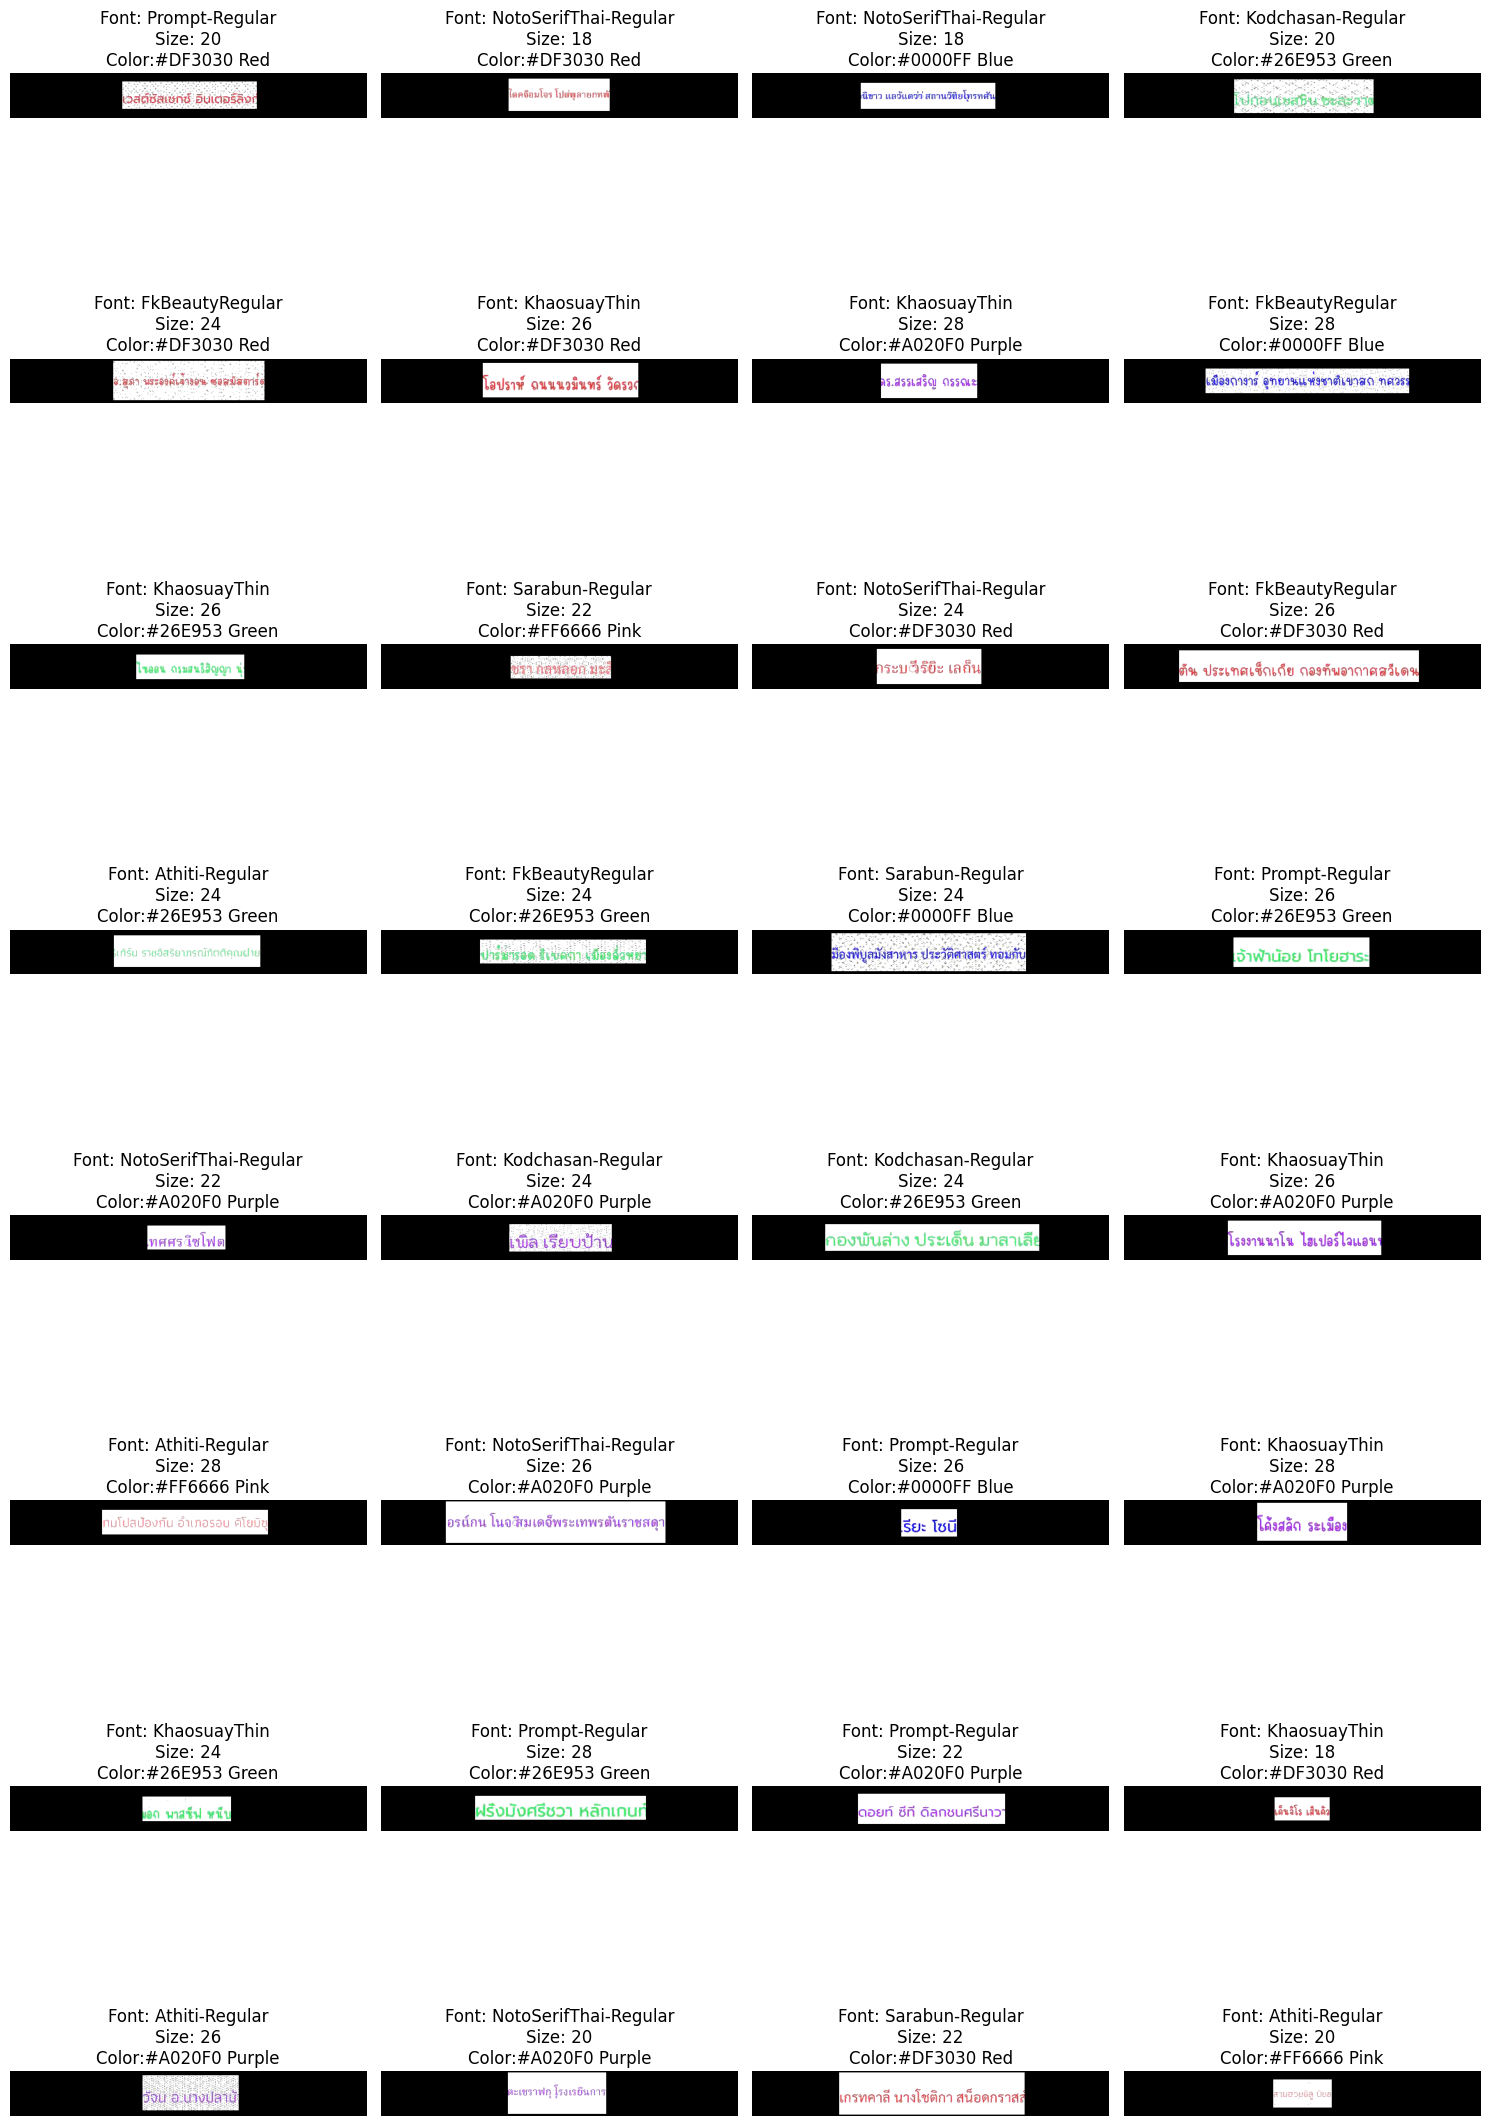

In [16]:
# TEST
color_name_map = {
    'FF6666': 'Pink',
    '0000FF': 'Blue',
    'A020F0': 'Purple',
    'DF3030': 'Red',
    '26E953': 'Green'
}
batch_size = 32
images, colors, fonts, font_sizes = next(iter(test_loader))

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = reverse_color_mapping[int(color)]
    # color_hex = color_name_map[color_name]
    font_name = reverse_font_mapping[int(font)]
    font_size_value = reverse_font_size_mapping[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor:#{color_name} {color_name_map[color_name]}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet(nn.Module):
    def __init__(self,
                 num_colors=5,
                 num_fonts=7,
                 num_sizes=6,
                 h_dims_color=[],
                 h_dims_font=[],
                 h_dims_size=[],
                 input_size=(3, 64, 512)):  # input_size is optional and unused for ResNet
        super(CustomResNet, self).__init__()

        self.resnet = models.resnet50(pretrained=True)

        # Freeze all layers except the fully connected layers
        for param in self.resnet.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer

        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.25))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)  # ResNet forward pass up to the final layer

        color_output = self.color_classifier(x)
        font_output = self.font_classifier(x)
        size_output = self.size_classifier(x)

        return color_output, font_output, size_output

In [18]:
num_colors = 5
num_fonts = 7
num_sizes = 6

In [19]:
best_score = 0.0

def calculate_fbeta_score(precision, recall, beta):
    beta_squared = beta ** 2
    return (1 + beta_squared) * (precision * recall) / ((beta_squared * precision) + recall + 1e-7)

def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          beta=1,
          checkpoint_path=None,
          device='cpu'):
    global best_score
    model = model.to(device)
    print("🤖 Training on", device)

    for epoch in range(epochs):
        model.train()
        cross_entropy_loss = nn.CrossEntropyLoss()

        train_bar = tqdm(train_loader,
                         desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        for batch_idx, (data, color_target, font_target, size_target) in enumerate(train_bar):
            data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

            optimizer.zero_grad()

            color_output, font_output, size_output = model(data)
            loss_color = cross_entropy_loss(color_output, color_target)
            loss_font = cross_entropy_loss(font_output, font_target)
            loss_size = cross_entropy_loss(size_output, size_target)

            loss = loss_color*0.5 + loss_font*1 + loss_size*1.5

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()


        correct_color, correct_font, correct_size = 0, 0, 0
        test_loss_color, test_loss_font, test_loss_size = 0, 0, 0

        all_color_preds, all_color_targets = [], []
        all_font_preds, all_font_targets = [], []
        all_size_preds, all_size_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader,
                            desc=f"🧪 Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            for data, color_target, font_target, size_target in test_bar:
                data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

                color_output, font_output, size_output = model(data)

                test_loss_color += cross_entropy_loss(color_output, color_target).item()
                test_loss_font += cross_entropy_loss(font_output, font_target).item()
                test_loss_size += cross_entropy_loss(size_output, size_target).item()

                color_pred = color_output.argmax(dim=1, keepdim=True)
                font_pred = font_output.argmax(dim=1, keepdim=True)
                size_pred = size_output.argmax(dim=1, keepdim=True)

                correct_color += color_pred.eq(color_target.view_as(color_pred)).sum().item()
                correct_font += font_pred.eq(font_target.view_as(font_pred)).sum().item()
                correct_size += size_pred.eq(size_target.view_as(size_pred)).sum().item()

                all_color_preds.extend(color_pred.cpu().numpy())
                all_color_targets.extend(color_target.cpu().numpy())
                all_font_preds.extend(font_pred.cpu().numpy())
                all_font_targets.extend(font_target.cpu().numpy())
                all_size_preds.extend(size_pred.cpu().numpy())
                all_size_targets.extend(size_target.cpu().numpy())

            test_loss_color /= len(test_loader.dataset)
            test_loss_font /= len(test_loader.dataset)
            test_loss_size /= len(test_loader.dataset)

            accuracy_color = 100. * correct_color / len(test_loader.dataset)
            accuracy_font = 100. * correct_font / len(test_loader.dataset)
            accuracy_size = 100. * correct_size / len(test_loader.dataset)

            precision_color = precision_score(all_color_targets, all_color_preds, average='weighted')
            recall_color = recall_score(all_color_targets, all_color_preds, average='weighted')
            precision_font = precision_score(all_font_targets, all_font_preds, average='weighted')
            recall_font = recall_score(all_font_targets, all_font_preds, average='weighted')
            precision_size = precision_score(all_size_targets, all_size_preds, average='weighted')
            recall_size = recall_score(all_size_targets, all_size_preds, average='weighted')

            fbeta_color = calculate_fbeta_score(precision_color, recall_color, beta)
            fbeta_font = calculate_fbeta_score(precision_font, recall_font, beta)
            fbeta_size = calculate_fbeta_score(precision_size, recall_size, beta)

            fbeta_total = (fbeta_font)*0.3 + (fbeta_color)*0.2 + (fbeta_size)*0.5

            print(f'Test set:')
            print(f'Average Color loss: {test_loss_color:.4f},🌈 F1: {fbeta_color:.4f}%')
            print(f'Average Font loss: {test_loss_font:.4f},🔤 F1: {fbeta_font:.4f}%')
            print(f'Average Size loss: {test_loss_size:.4f},🔢 F1: {fbeta_size:.4f}%')

            print(f'👽 Real Score (Total F-beta): {fbeta_total:.4f}')

            if fbeta_total > best_score:
                best_score = fbeta_total
                if checkpoint_path:
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f'# 🧠 Best model saved with F-beta Score: {fbeta_total:.4f} at epoch {epoch+1} 🧠')

In [21]:
model = CustomResNet(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128], h_dims_font=[1024, 512,256],h_dims_size=[2048,1024,512])
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=50,
      beta=2,
      checkpoint_path="C:/Users/ASUS/NextgenAI/Check_point.pth",
      device=device)

print(f"😎 Best Score is {best_score:.4f}")

c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


🧪 Testing Epoch [1/50]: 100%|██████████| 63/63 [00:05<00:00, 11.58batch/s]
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test set:
Average Color loss: 0.0127,🌈 F1: 0.9162%
Average Font loss: 0.0593,🔤 F1: 0.3270%
Average Size loss: 0.0478,🔢 F1: 0.2783%
👽 Real Score (Total F-beta): 0.4205
# 🧠 Best model saved with F-beta Score: 0.4205 at epoch 1 🧠


🧪 Testing Epoch [2/50]: 100%|██████████| 63/63 [00:05<00:00, 11.50batch/s]


Test set:
Average Color loss: 0.0038,🌈 F1: 0.9921%
Average Font loss: 0.0455,🔤 F1: 0.3908%
Average Size loss: 0.0381,🔢 F1: 0.4305%
👽 Real Score (Total F-beta): 0.5309
# 🧠 Best model saved with F-beta Score: 0.5309 at epoch 2 🧠


🧪 Testing Epoch [3/50]: 100%|██████████| 63/63 [00:05<00:00, 11.05batch/s]


Test set:
Average Color loss: 0.0015,🌈 F1: 0.9960%
Average Font loss: 0.0335,🔤 F1: 0.5504%
Average Size loss: 0.0324,🔢 F1: 0.5551%
👽 Real Score (Total F-beta): 0.6419
# 🧠 Best model saved with F-beta Score: 0.6419 at epoch 3 🧠


🧪 Testing Epoch [4/50]: 100%|██████████| 63/63 [00:05<00:00, 11.23batch/s]


Test set:
Average Color loss: 0.0010,🌈 F1: 0.9980%
Average Font loss: 0.0280,🔤 F1: 0.6336%
Average Size loss: 0.0303,🔢 F1: 0.5739%
👽 Real Score (Total F-beta): 0.6766
# 🧠 Best model saved with F-beta Score: 0.6766 at epoch 4 🧠


🧪 Testing Epoch [5/50]: 100%|██████████| 63/63 [00:05<00:00, 10.97batch/s]


Test set:
Average Color loss: 0.0008,🌈 F1: 0.9990%
Average Font loss: 0.0237,🔤 F1: 0.7063%
Average Size loss: 0.0267,🔢 F1: 0.6468%
👽 Real Score (Total F-beta): 0.7351
# 🧠 Best model saved with F-beta Score: 0.7351 at epoch 5 🧠


🧪 Testing Epoch [6/50]: 100%|██████████| 63/63 [00:05<00:00, 10.51batch/s]


Test set:
Average Color loss: 0.0007,🌈 F1: 0.9985%
Average Font loss: 0.0169,🔤 F1: 0.7832%
Average Size loss: 0.0261,🔢 F1: 0.6431%
👽 Real Score (Total F-beta): 0.7562
# 🧠 Best model saved with F-beta Score: 0.7562 at epoch 6 🧠


🧪 Testing Epoch [7/50]: 100%|██████████| 63/63 [00:05<00:00, 11.11batch/s]


Test set:
Average Color loss: 0.0004,🌈 F1: 1.0000%
Average Font loss: 0.0142,🔤 F1: 0.8222%
Average Size loss: 0.0248,🔢 F1: 0.6622%
👽 Real Score (Total F-beta): 0.7777
# 🧠 Best model saved with F-beta Score: 0.7777 at epoch 7 🧠


🧪 Testing Epoch [8/50]: 100%|██████████| 63/63 [00:05<00:00, 11.27batch/s]


Test set:
Average Color loss: 0.0003,🌈 F1: 0.9995%
Average Font loss: 0.0108,🔤 F1: 0.8817%
Average Size loss: 0.0227,🔢 F1: 0.6933%
👽 Real Score (Total F-beta): 0.8111
# 🧠 Best model saved with F-beta Score: 0.8111 at epoch 8 🧠


🧪 Testing Epoch [9/50]: 100%|██████████| 63/63 [00:05<00:00, 11.16batch/s]


Test set:
Average Color loss: 0.0003,🌈 F1: 0.9990%
Average Font loss: 0.0091,🔤 F1: 0.8898%
Average Size loss: 0.0216,🔢 F1: 0.7322%
👽 Real Score (Total F-beta): 0.8328
# 🧠 Best model saved with F-beta Score: 0.8328 at epoch 9 🧠


🧪 Testing Epoch [10/50]: 100%|██████████| 63/63 [00:05<00:00, 11.26batch/s]


Test set:
Average Color loss: 0.0002,🌈 F1: 0.9995%
Average Font loss: 0.0079,🔤 F1: 0.9083%
Average Size loss: 0.0213,🔢 F1: 0.7236%
👽 Real Score (Total F-beta): 0.8342
# 🧠 Best model saved with F-beta Score: 0.8342 at epoch 10 🧠


🧪 Testing Epoch [11/50]: 100%|██████████| 63/63 [00:05<00:00, 11.29batch/s]


Test set:
Average Color loss: 0.0002,🌈 F1: 0.9995%
Average Font loss: 0.0067,🔤 F1: 0.9233%
Average Size loss: 0.0203,🔢 F1: 0.7474%
👽 Real Score (Total F-beta): 0.8506
# 🧠 Best model saved with F-beta Score: 0.8506 at epoch 11 🧠


🧪 Testing Epoch [12/50]: 100%|██████████| 63/63 [00:06<00:00, 10.46batch/s]


Test set:
Average Color loss: 0.0002,🌈 F1: 0.9990%
Average Font loss: 0.0065,🔤 F1: 0.9201%
Average Size loss: 0.0193,🔢 F1: 0.7574%
👽 Real Score (Total F-beta): 0.8545
# 🧠 Best model saved with F-beta Score: 0.8545 at epoch 12 🧠


🧪 Testing Epoch [13/50]: 100%|██████████| 63/63 [00:05<00:00, 10.63batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 1.0000%
Average Font loss: 0.0051,🔤 F1: 0.9408%
Average Size loss: 0.0190,🔢 F1: 0.7794%
👽 Real Score (Total F-beta): 0.8720
# 🧠 Best model saved with F-beta Score: 0.8720 at epoch 13 🧠


🧪 Testing Epoch [14/50]: 100%|██████████| 63/63 [00:05<00:00, 11.09batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0048,🔤 F1: 0.9440%
Average Size loss: 0.0178,🔢 F1: 0.7940%
👽 Real Score (Total F-beta): 0.8801
# 🧠 Best model saved with F-beta Score: 0.8801 at epoch 14 🧠


🧪 Testing Epoch [15/50]: 100%|██████████| 63/63 [00:05<00:00, 11.23batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 1.0000%
Average Font loss: 0.0047,🔤 F1: 0.9509%
Average Size loss: 0.0174,🔢 F1: 0.7976%
👽 Real Score (Total F-beta): 0.8841
# 🧠 Best model saved with F-beta Score: 0.8841 at epoch 15 🧠


🧪 Testing Epoch [16/50]: 100%|██████████| 63/63 [00:05<00:00, 11.30batch/s]


Test set:
Average Color loss: 0.0002,🌈 F1: 0.9980%
Average Font loss: 0.0045,🔤 F1: 0.9435%
Average Size loss: 0.0178,🔢 F1: 0.7879%
👽 Real Score (Total F-beta): 0.8766


🧪 Testing Epoch [17/50]: 100%|██████████| 63/63 [00:05<00:00, 11.31batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0042,🔤 F1: 0.9534%
Average Size loss: 0.0166,🔢 F1: 0.8001%
👽 Real Score (Total F-beta): 0.8860
# 🧠 Best model saved with F-beta Score: 0.8860 at epoch 17 🧠


🧪 Testing Epoch [18/50]: 100%|██████████| 63/63 [00:05<00:00, 11.04batch/s]


Test set:
Average Color loss: 0.0002,🌈 F1: 0.9985%
Average Font loss: 0.0040,🔤 F1: 0.9549%
Average Size loss: 0.0182,🔢 F1: 0.7840%
👽 Real Score (Total F-beta): 0.8781


🧪 Testing Epoch [19/50]: 100%|██████████| 63/63 [00:05<00:00, 10.68batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0041,🔤 F1: 0.9521%
Average Size loss: 0.0181,🔢 F1: 0.7845%
👽 Real Score (Total F-beta): 0.8778


🧪 Testing Epoch [20/50]: 100%|██████████| 63/63 [00:05<00:00, 10.80batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 1.0000%
Average Font loss: 0.0033,🔤 F1: 0.9609%
Average Size loss: 0.0160,🔢 F1: 0.8153%
👽 Real Score (Total F-beta): 0.8959
# 🧠 Best model saved with F-beta Score: 0.8959 at epoch 20 🧠


🧪 Testing Epoch [21/50]: 100%|██████████| 63/63 [00:05<00:00, 11.05batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 0.9995%
Average Font loss: 0.0040,🔤 F1: 0.9554%
Average Size loss: 0.0159,🔢 F1: 0.8104%
👽 Real Score (Total F-beta): 0.8917


🧪 Testing Epoch [22/50]: 100%|██████████| 63/63 [00:05<00:00, 11.20batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0038,🔤 F1: 0.9584%
Average Size loss: 0.0169,🔢 F1: 0.8120%
👽 Real Score (Total F-beta): 0.8935


🧪 Testing Epoch [23/50]: 100%|██████████| 63/63 [00:05<00:00, 11.23batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 1.0000%
Average Font loss: 0.0042,🔤 F1: 0.9544%
Average Size loss: 0.0145,🔢 F1: 0.8245%
👽 Real Score (Total F-beta): 0.8986
# 🧠 Best model saved with F-beta Score: 0.8986 at epoch 23 🧠


🧪 Testing Epoch [24/50]: 100%|██████████| 63/63 [00:05<00:00, 11.25batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0039,🔤 F1: 0.9583%
Average Size loss: 0.0155,🔢 F1: 0.8271%
👽 Real Score (Total F-beta): 0.9010
# 🧠 Best model saved with F-beta Score: 0.9010 at epoch 24 🧠


🧪 Testing Epoch [25/50]: 100%|██████████| 63/63 [00:05<00:00, 11.25batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0041,🔤 F1: 0.9532%
Average Size loss: 0.0152,🔢 F1: 0.8277%
👽 Real Score (Total F-beta): 0.8997


🧪 Testing Epoch [26/50]: 100%|██████████| 63/63 [00:05<00:00, 11.13batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0037,🔤 F1: 0.9625%
Average Size loss: 0.0150,🔢 F1: 0.8325%
👽 Real Score (Total F-beta): 0.9049
# 🧠 Best model saved with F-beta Score: 0.9049 at epoch 26 🧠


🧪 Testing Epoch [27/50]: 100%|██████████| 63/63 [00:05<00:00, 11.19batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0036,🔤 F1: 0.9599%
Average Size loss: 0.0150,🔢 F1: 0.8379%
👽 Real Score (Total F-beta): 0.9068
# 🧠 Best model saved with F-beta Score: 0.9068 at epoch 27 🧠


🧪 Testing Epoch [28/50]: 100%|██████████| 63/63 [00:05<00:00, 11.15batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0039,🔤 F1: 0.9550%
Average Size loss: 0.0158,🔢 F1: 0.8356%
👽 Real Score (Total F-beta): 0.9043


🧪 Testing Epoch [29/50]: 100%|██████████| 63/63 [00:05<00:00, 11.23batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0033,🔤 F1: 0.9633%
Average Size loss: 0.0150,🔢 F1: 0.8381%
👽 Real Score (Total F-beta): 0.9080
# 🧠 Best model saved with F-beta Score: 0.9080 at epoch 29 🧠


🧪 Testing Epoch [30/50]: 100%|██████████| 63/63 [00:05<00:00, 11.32batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0029,🔤 F1: 0.9673%
Average Size loss: 0.0140,🔢 F1: 0.8451%
👽 Real Score (Total F-beta): 0.9126
# 🧠 Best model saved with F-beta Score: 0.9126 at epoch 30 🧠


🧪 Testing Epoch [31/50]: 100%|██████████| 63/63 [00:05<00:00, 11.24batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0037,🔤 F1: 0.9624%
Average Size loss: 0.0162,🔢 F1: 0.8258%
👽 Real Score (Total F-beta): 0.9015


🧪 Testing Epoch [32/50]: 100%|██████████| 63/63 [00:06<00:00, 10.43batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9990%
Average Font loss: 0.0036,🔤 F1: 0.9590%
Average Size loss: 0.0159,🔢 F1: 0.8360%
👽 Real Score (Total F-beta): 0.9055


🧪 Testing Epoch [33/50]: 100%|██████████| 63/63 [00:05<00:00, 11.09batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0036,🔤 F1: 0.9648%
Average Size loss: 0.0161,🔢 F1: 0.8231%
👽 Real Score (Total F-beta): 0.9010


🧪 Testing Epoch [34/50]: 100%|██████████| 63/63 [00:05<00:00, 11.08batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0034,🔤 F1: 0.9658%
Average Size loss: 0.0141,🔢 F1: 0.8491%
👽 Real Score (Total F-beta): 0.9143
# 🧠 Best model saved with F-beta Score: 0.9143 at epoch 34 🧠


🧪 Testing Epoch [35/50]: 100%|██████████| 63/63 [00:05<00:00, 11.18batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0036,🔤 F1: 0.9608%
Average Size loss: 0.0161,🔢 F1: 0.8307%
👽 Real Score (Total F-beta): 0.9036


🧪 Testing Epoch [36/50]: 100%|██████████| 63/63 [00:05<00:00, 11.38batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0029,🔤 F1: 0.9698%
Average Size loss: 0.0146,🔢 F1: 0.8522%
👽 Real Score (Total F-beta): 0.9170
# 🧠 Best model saved with F-beta Score: 0.9170 at epoch 36 🧠


🧪 Testing Epoch [37/50]: 100%|██████████| 63/63 [00:05<00:00, 11.40batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0032,🔤 F1: 0.9668%
Average Size loss: 0.0156,🔢 F1: 0.8475%
👽 Real Score (Total F-beta): 0.9138


🧪 Testing Epoch [38/50]: 100%|██████████| 63/63 [00:05<00:00, 11.42batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0031,🔤 F1: 0.9663%
Average Size loss: 0.0158,🔢 F1: 0.8361%
👽 Real Score (Total F-beta): 0.9079


🧪 Testing Epoch [39/50]: 100%|██████████| 63/63 [00:05<00:00, 11.41batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9995%
Average Font loss: 0.0034,🔤 F1: 0.9648%
Average Size loss: 0.0144,🔢 F1: 0.8442%
👽 Real Score (Total F-beta): 0.9115


🧪 Testing Epoch [40/50]: 100%|██████████| 63/63 [00:05<00:00, 11.32batch/s]


Test set:
Average Color loss: 0.0001,🌈 F1: 0.9990%
Average Font loss: 0.0032,🔤 F1: 0.9668%
Average Size loss: 0.0157,🔢 F1: 0.8407%
👽 Real Score (Total F-beta): 0.9102


🧪 Testing Epoch [41/50]: 100%|██████████| 63/63 [00:05<00:00, 10.95batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0029,🔤 F1: 0.9663%
Average Size loss: 0.0141,🔢 F1: 0.8577%
👽 Real Score (Total F-beta): 0.9188
# 🧠 Best model saved with F-beta Score: 0.9188 at epoch 41 🧠


🧪 Testing Epoch [42/50]: 100%|██████████| 63/63 [00:05<00:00, 11.26batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0028,🔤 F1: 0.9698%
Average Size loss: 0.0124,🔢 F1: 0.8640%
👽 Real Score (Total F-beta): 0.9229
# 🧠 Best model saved with F-beta Score: 0.9229 at epoch 42 🧠


🧪 Testing Epoch [43/50]: 100%|██████████| 63/63 [00:05<00:00, 11.18batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0034,🔤 F1: 0.9648%
Average Size loss: 0.0140,🔢 F1: 0.8574%
👽 Real Score (Total F-beta): 0.9181


🧪 Testing Epoch [44/50]: 100%|██████████| 63/63 [00:05<00:00, 11.23batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0027,🔤 F1: 0.9702%
Average Size loss: 0.0159,🔢 F1: 0.8405%
👽 Real Score (Total F-beta): 0.9113


🧪 Testing Epoch [45/50]: 100%|██████████| 63/63 [00:05<00:00, 11.31batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0030,🔤 F1: 0.9673%
Average Size loss: 0.0142,🔢 F1: 0.8614%
👽 Real Score (Total F-beta): 0.9209


🧪 Testing Epoch [46/50]: 100%|██████████| 63/63 [00:05<00:00, 11.21batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 0.9995%
Average Font loss: 0.0034,🔤 F1: 0.9639%
Average Size loss: 0.0156,🔢 F1: 0.8538%
👽 Real Score (Total F-beta): 0.9160


🧪 Testing Epoch [47/50]: 100%|██████████| 63/63 [00:05<00:00, 11.30batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0031,🔤 F1: 0.9707%
Average Size loss: 0.0149,🔢 F1: 0.8630%
👽 Real Score (Total F-beta): 0.9227


🧪 Testing Epoch [48/50]: 100%|██████████| 63/63 [00:05<00:00, 11.06batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0044,🔤 F1: 0.9600%
Average Size loss: 0.0145,🔢 F1: 0.8616%
👽 Real Score (Total F-beta): 0.9188


🧪 Testing Epoch [49/50]: 100%|██████████| 63/63 [00:05<00:00, 11.30batch/s]


Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0025,🔤 F1: 0.9733%
Average Size loss: 0.0143,🔢 F1: 0.8671%
👽 Real Score (Total F-beta): 0.9255
# 🧠 Best model saved with F-beta Score: 0.9255 at epoch 49 🧠


🧪 Testing Epoch [50/50]: 100%|██████████| 63/63 [00:05<00:00, 11.05batch/s]

Test set:
Average Color loss: 0.0000,🌈 F1: 1.0000%
Average Font loss: 0.0026,🔤 F1: 0.9758%
Average Size loss: 0.0130,🔢 F1: 0.8698%
👽 Real Score (Total F-beta): 0.9276
# 🧠 Best model saved with F-beta Score: 0.9276 at epoch 50 🧠
😎 Best Score is 0.9276


In [22]:
model = CustomResNet(num_colors, num_fonts, num_sizes, h_dims_color=[256, 128], h_dims_font=[1024, 512,256],h_dims_size=[2048,1024,512])
model.load_state_dict(torch.load("C:/Users/ASUS/NextgenAI/Check_point.pth"))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

file_names, font_preds, size_preds, color_preds = [], [], [], []

submit_transform  = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    BilateralFilter(d=5, sigmaColor=60, sigmaSpace=60),   
    RemoveWhiteNoiseAndBackground(),              
    transforms.CenterCrop((64, 512)),
    transforms.ToTensor(),
    ])

csv_file = 'C:/Users/ASUS/NextgenAI/test.csv'
df = pd.read_csv(csv_file)

file_paths_from_csv = df.iloc[:, 0]

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

with torch.no_grad():
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')
    for img_path in submit_bar:

        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue
        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        color_output, font_output, size_output = model(image)

        color_pred = color_output.argmax(dim=1, keepdim=True).item()
        color_preds.append(f"#{reverse_color_mapping[color_pred]}")

        font_pred = font_output.argmax(dim=1, keepdim=True).item()
        font_preds.append(reverse_font_mapping[font_pred])

        size_pred = size_output.argmax(dim=1, keepdim=True).item()
        size_preds.append(reverse_font_size_mapping[size_pred])

        file_name = os.path.basename(img_path)
        file_names.append(f"images/{file_name}")

data = list(zip(file_names, font_preds, size_preds, color_preds))
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

output_path = 'C:/Users/ASUS/NextgenAI/FixedWorkshop.csv'
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27484\1889261267.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

CSV file saved to C:/Users/ASUS/NextgenAI/FixedWorkshop.csv
